# 1. Should we remove the bias parameter from the fully connected layer or the convolutional layer before the batch normalization? Why?



Batch normalization is a technique that helps stabilize and accelerate the training of deep neural networks. It normalizes the activations within a layer by subtracting the mean and dividing by the standard deviation of the mini-batch. The normalized activations are then scaled and shifted using learnable parameters: the scale (gamma) and shift (beta) parameters.

When using batch normalization, it's generally recommended to remove the bias parameter from the fully connected (linear) layer before applying batch normalization. This recommendation comes from the idea that the normalization process already includes shifting the activations with the beta parameter of batch normalization. Adding an additional bias term can introduce redundancy and might negatively impact the learning process.

For convolutional layers, the use of bias parameters is less clear-cut. Whether to use bias parameters before batch normalization in convolutional layers depends on your specific use case and the design choices you are making.

Here's a general guideline for both cases:

1. **Fully Connected (Linear) Layer**:
   - **Remove Bias**: It's recommended to remove the bias parameter from the fully connected layer before applying batch normalization. This helps avoid the potential redundancy between the bias and beta parameters of batch normalization.
   
2. **Convolutional Layer**:
   - **With Bias**: Some architectures and setups use bias parameters in convolutional layers before batch normalization. The bias parameter can still provide flexibility in modeling, especially in the early stages of the network.
   - **Without Bias**: If you decide to remove the bias parameter from convolutional layers before batch normalization, you're essentially letting batch normalization handle both the shifting and scaling of the activations.

Remember that the effectiveness of these choices can also depend on the specific architecture, dataset, and optimization process you're using. It's often a good idea to experiment with different configurations to find the best setup for your particular use case.

In summary, for fully connected layers, it's generally recommended to remove the bias parameter before applying batch normalization. For convolutional layers, you have some flexibility and can choose to include or exclude bias parameters based on your design choices and performance considerations.

# 2. Compare the learning rates for LeNet with and without batch normalization.



In [4]:
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))
        
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))
        
def stat_model_acc(model, data, plot_flag):
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer = d2l.Trainer(max_epochs=10, num_gpus=1,plot_flag=plot_flag)
    trainer.fit(model, data)
    X,y = next(iter(data.get_dataloader(False)))
    X = X.to('cuda')
    y = y.to('cuda')
    y_hat = model(X) 
    return model.accuracy(y_hat,y).item()

## 2.1 Plot the increase in validation accuracy.



In [2]:
data = d2l.FashionMNIST(batch_size=128)
lr_list = [0.001,0.01,0.03,0.1,0.3]
le_accs= []
ble_accs = []
for lr in lr_list[:1]:
    le = LeNet(lr=lr)
    ble = BNLeNet(lr=lr)
    le_acc.append(stat_model_acc(le, data, False))
    ble_acc.append(stat_model_acc(ble, data, False))

## 2.2 How large can you make the learning rate before the optimization fails in both cases?



# 3. Do we need batch normalization in every layer? Experiment with it.



Whether to apply batch normalization in every layer of a neural network is not a strict rule but a design choice that depends on the specific problem, architecture, and training dynamics. The decision can impact the model's convergence, performance, and training stability. Here are some considerations to help you decide:

**Advantages of Batch Normalization in Every Layer:**

1. **Stabilized Training**: Applying batch normalization in every layer helps stabilize training by normalizing activations and reducing internal covariate shifts, which can lead to faster convergence and more stable gradient propagation.

2. **Regularization**: Batch normalization has an inherent regularization effect, which can help prevent overfitting. Applying it in every layer might provide consistent regularization throughout the network.

3. **Deeper Architectures**: For very deep networks, applying batch normalization in every layer can help mitigate gradient vanishing/exploding problems, enabling the training of even deeper models.

4. **Less Sensitive to Initialization**: Batch normalization can reduce the sensitivity to weight initialization, allowing you to use larger learning rates and more aggressive optimization techniques.

**Considerations Against Batch Normalization in Every Layer:**

1. **Reduced Model Capacity**: Batch normalization can suppress the network's capacity to fit the training data. Applying it too frequently might lead to underfitting, especially in smaller models.

2. **Slower Training**: Adding batch normalization to every layer increases computational overhead, which might slow down training, especially on hardware with limited resources.

3. **Loss of Expressiveness**: Excessive normalization can remove useful information from activations, potentially limiting the model's expressiveness. It can also hinder the model's ability to memorize certain patterns, which could be desirable in some scenarios.

4. **Unstable for Very Small Batches**: Batch normalization relies on batch statistics, which can be unstable for very small batches. In such cases, using batch normalization in every layer might lead to poor performance.

**Guidelines and Best Practices:**

1. **Experiment**: It's recommended to experiment with different configurations, including applying batch normalization selectively or in every layer. Test the impact on validation performance, convergence speed, and generalization.

2. **Network Depth**: Deeper networks tend to benefit more from batch normalization in every layer due to the vanishing gradient problem. For shallower networks, you might achieve good results with selective application.

3. **Use Validation**: Monitor validation performance during training to detect potential overfitting caused by excessive batch normalization.

4. **Small Datasets**: For small datasets, you might need to be more cautious with normalization. Experiment with validation performance to find the right balance.

5. **Different Architectures**: Different architectures might respond differently to batch normalization. What works for one architecture might not work optimally for another.

In conclusion, while applying batch normalization in every layer can have benefits, it's important to consider the trade-offs and experiment with different configurations. The choice depends on your specific use case, the architecture of your model, the dataset, and computational constraints.

# 4. Implement a “lite” version of batch normalization that only removes the mean, or alternatively one that only removes the variance. How does it behave?

In [ ]:
def lite_batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum, mean_flag):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        if mean_flag:
            X_hat = X - moving_mean
        else:
            X_hat = X / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        if mean_flag:
            X_hat = X - mean
        else:
            X_hat = X / torch.sqrt(moving_var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

class LiteBatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims, mean_flag=True):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        self.mean_flag = mean_flag

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1, mean_flag=self.mean_flag)
        return Y

    
class LiteBNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10, mean_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), LiteBatchNorm(6, num_dims=4, mean_flag=mean_flag),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), LiteBatchNorm(16, num_dims=4, mean_flag=mean_flag),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            LiteBatchNorm(120, num_dims=2, mean_flag=mean_flag), nn.Sigmoid(), nn.LazyLinear(84),
            LiteBatchNorm(84, num_dims=2, mean_flag=mean_flag), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [ ]:
model = LiteBNLeNetScratch(lr=0.1)
stat_model_acc(model, data, True)

In [ ]:
model = LiteBNLeNetScratch(lr=0.1,mean_flag=False)
stat_model_acc(model, data, True)

# 5. Fix the parameters beta and gamma. Observe and analyze the results.



In [ ]:
class FixedBatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims, beta=None, gamma=None):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = torch.ones(shape) if gamma is None else gamma
        self.beta = torch.zeros(shape) if beta is None else beta
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        self.mean_flag = mean_flag

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1, mean_flag=self.mean_flag)
        return Y

    
class FixedBNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10, beta=None, gamma=None):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), FixedBatchNorm(6, num_dims=4, beta=beta, gamma=gamma),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), FixedBatchNorm(16, num_dims=4, beta=beta, gamma=gamma),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            FixedBatchNorm(120, num_dims=2, beta=beta, gamma=gamma), nn.Sigmoid(), nn.LazyLinear(84),
            FixedBatchNorm(84, num_dims=2, beta=beta, gamma=gamma), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

# 6. Can you replace dropout by batch normalization? How does the behavior change?



Dropout and batch normalization are two different techniques used for regularization in neural networks. While they both aim to prevent overfitting, they operate in distinct ways. Dropout involves randomly dropping out units (neurons) during training, while batch normalization normalizes activations in each layer. They serve different purposes, and replacing one with the other may not yield the same results.

# 7. Research ideas: think of other normalization transforms that you can apply:



## 7.1 Can you apply the probability integral transform?



In [21]:
from scipy.stats import norm

data = [1,2,3]
sorted_data = np.sort(data)
cdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
transformed_data = norm.ppf(cdf_values)  # Applying inverse CDF of normal distribution
transformed_data

array([-0.4307273,  0.4307273,        inf])

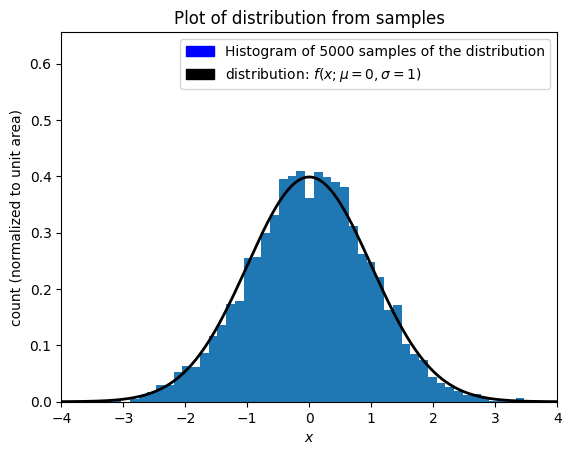

In [13]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
x = np.linspace(-5.0, 5.0, num=10000)
# mean and standard deviation
mu = 0
sigma = 1

# sample the distribution
number_of_samples = 5000
samples = np.random.normal(mu, sigma, number_of_samples)
samples.sort()
sample_mean = np.mean(samples)
sample_std = np.std(samples)
true_distribution = stats.norm.pdf(x, mu, sigma)
n_bins = 1
if number_of_samples < 50:
    n_bins = number_of_samples
else:
    n_bins = 50

# Plots
plt.figure(1)

# Plot histogram of samples
hist_count, bins, _ = plt.hist(
    samples, n_bins, density=True
)  # Norm to keep distribution in view
# Plot distribution using sample parameters
plt.plot(x, true_distribution, linewidth=2, color="black")

# Axes
plt.title("Plot of distribution from samples")
plt.xlabel("$x$")
plt.ylabel("count (normalized to unit area)")
sample_window_w = sample_std * 1.5
# plt.xlim([sample_mean - sample_window_w, sample_mean + sample_window_w])
plt.xlim([-4, 4])
plt.ylim([0, hist_count.max() * 1.6])

# Legends
sample_patch = mpatches.Patch(
    color="black", label=fr"distribution: $f(x;\mu={mu},\sigma={sigma})$"
)
data_patch = mpatches.Patch(
    color="blue",
    label=f"Histogram of {number_of_samples} samples of the distribution",
)

plt.legend(handles=[data_patch, sample_patch])

plt.show()
# print(samples)

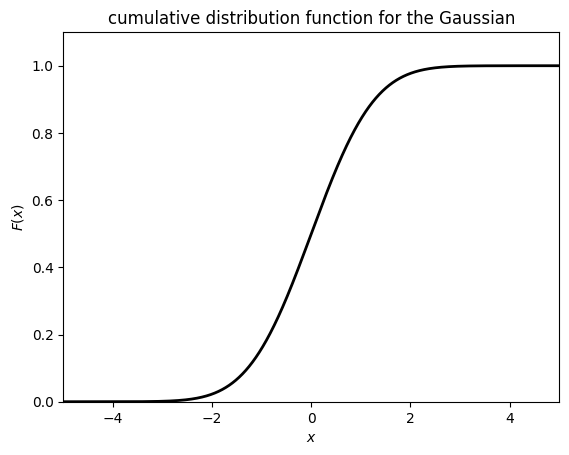

In [15]:
# Plots
plt.figure(1)

# Plot distribution using sample parameters
plt.plot(x, stats.norm.cdf(x), linewidth=2, color="black")

# Axes
plt.title("cumulative distribution function for the Gaussian")
plt.xlabel("$x$")
plt.ylabel("$F(x)$")

plt.xlim([-5, 5])
plt.ylim([0, 1.1])

plt.show()

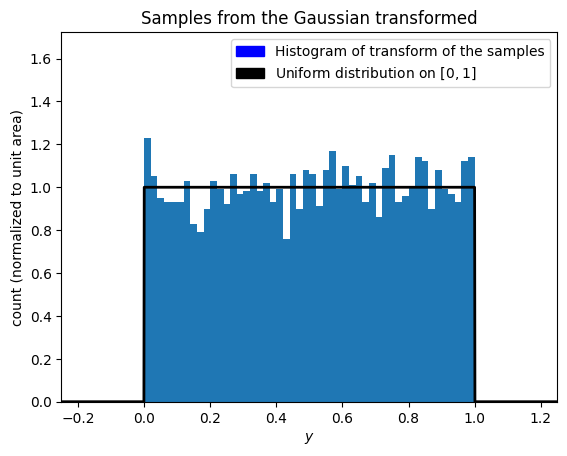

In [17]:
output = stats.norm.cdf(samples)
uniform_distribution = stats.uniform.pdf(x)
# Plots
plt.figure(1)

# Plot histogram of samples
hist_count, bins, _ = plt.hist(
    output, n_bins, density=True
)  # Norm to keep distribution in view
# Plot distribution using sample parameters
plt.plot(x, uniform_distribution, linewidth=2, color="black")
# Axes
plt.title("Samples from the Gaussian transformed")
plt.xlabel("$y$")
plt.ylabel("count (normalized to unit area)")

plt.xlim([-0.25, 1.25])
plt.ylim([0, hist_count.max() * 1.4])

# Legends
sample_patch = mpatches.Patch(
    color="black", label=f"Uniform distribution on $[{0},{1}]$"
)
data_patch = mpatches.Patch(color="blue", label="Histogram of transform of the samples")

plt.legend(handles=[data_patch, sample_patch])

plt.show()

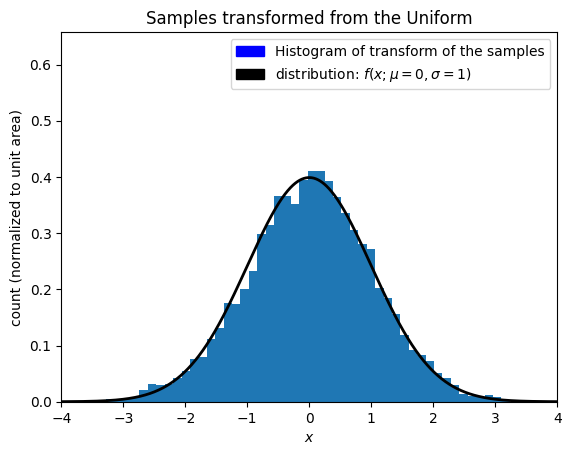

In [18]:
recovered = stats.norm.ppf(output)
# Plots
plt.figure(1)

# Plot histogram of samples
hist_count, bins, _ = plt.hist(
    recovered, n_bins, density=True
)  # Norm to keep distribution in view
# Plot distribution using sample parameters
plt.plot(x, true_distribution, linewidth=2, color="black")
# Axes
plt.title("Samples transformed from the Uniform")
plt.xlabel("$x$")
plt.ylabel("count (normalized to unit area)")

plt.xlim([-4, 4])
plt.ylim([0, hist_count.max() * 1.6])

# Legends
sample_patch = mpatches.Patch(
    color="black", label=fr"distribution: $f(x;\mu={mu},\sigma={sigma})$"
)
data_patch = mpatches.Patch(color="blue", label="Histogram of transform of the samples")

plt.legend(handles=[data_patch, sample_patch])

plt.show()

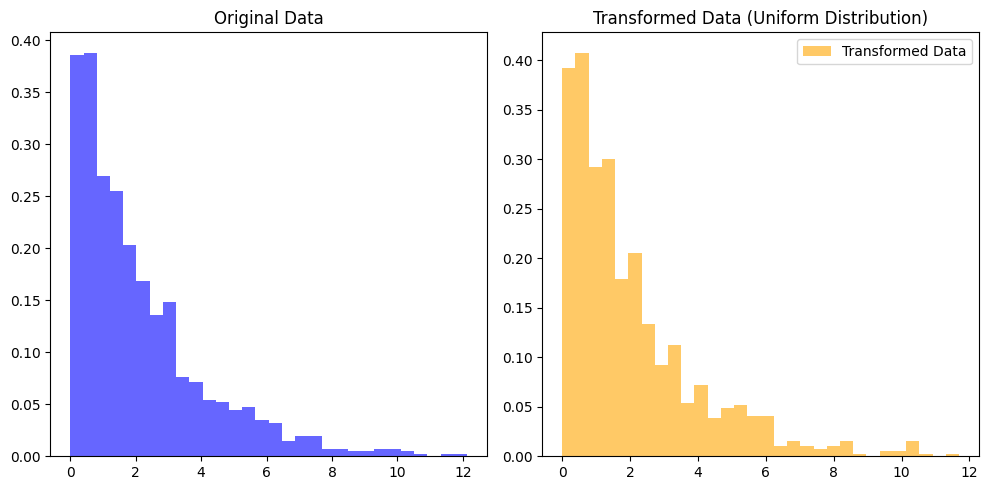

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data from a non-uniform distribution (e.g., exponential)
data = np.random.exponential(scale=2, size=1000)

# Sort the data in ascending order
sorted_data = np.sort(data)

# Calculate the CDF values
cdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Apply the inverse CDF to map the data to a uniform distribution
uniform_samples = np.random.uniform(size=len(data))
transformed_data = np.interp(uniform_samples, cdf_values, sorted_data)

# Plot original data and transformed data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(data, bins=30, density=True, alpha=0.6, color='blue', label='Original Data')
plt.title('Original Data')
plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins=30, density=True, alpha=0.6, color='orange', label='Transformed Data')
plt.title('Transformed Data (Uniform Distribution)')
plt.legend()
plt.tight_layout()
plt.show()


## 7.2 Can you use a full-rank covariance estimate? Why should you probably not do that?


## 7.3 Can you use other compact matrix variants (block-diagonal, low-displacement rank, Monarch, etc.)?



## 7.4 Does a sparsification compression act as a regularizer?



## 7.5 Are there other projections (e.g., convex cone, symmetry group-specific transforms) that you can use?